# Plotting Winston
In this notebook we will create a windbarb map during TC Winston

In [13]:
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.colors as mcolors

In [2]:
file_path = 'D:/Projects/fiji-training-2024/notebooks/day_07/tc_winston.grib'
ds = xr.open_dataset(file_path, engine='cfgrib')
ds

<xarray.Dataset>
Dimensions:     (time: 264, latitude: 121, longitude: 121)
Coordinates:
    number      int32 ...
  * time        (time) datetime64[ns] 2016-02-15 ... 2016-02-25T23:00:00
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 0.0 -0.25 -0.5 -0.75 ... -29.5 -29.75 -30.0
  * longitude   (longitude) float64 150.0 150.2 150.5 ... 179.5 179.8 180.0
    valid_time  (time) datetime64[ns] ...
Data variables:
    u10         (time, latitude, longitude) float32 ...
    v10         (time, latitude, longitude) float32 ...
    msl         (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-07-01T19:06 GRIB to CDM+CF via cfgrib-0.9.1...

# Part 2 : Prepare the Data

In [60]:
# Select the time and assign to a variable
time_select = datetime(2016,2,24,0)
u10 = ds['u10'].sel(time=time_select)
v10 = ds['v10'].sel(time=time_select)
msl = ds['msl'].sel(time=time_select)
u10 = u10 * 1.94 # Convert to knot
v10 = v10 * 1.94 # Convert to knot
msl = msl / 100 # Convert to hPa
lons = u10.longitude
lats = u10.latitude
ws10 = np.sqrt(u10**2 + v10**2)

In [61]:
# Subsample the data
step = 5
lons_sub = lons[::step]
lats_sub = lats[::step]
u10 = u10[::step,::step]
v10 = v10[::step,::step]

In [62]:
# Create a grid
lon, lat = np.meshgrid(lons_sub, lats_sub)

In [63]:
# Make flip barbs array containing True if the latitude is < 0 and False if it's >= 0
flip_barbs = lat < 0
flip_barbs

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True],


In [64]:
# Find the indices of the minimum MSLP value
min_index = msl.argmin(dim=['latitude', 'longitude'])

# Retrieve the latitude and longitude values at the minimum MSLP location
tc_lat = msl['latitude'][min_index['latitude']]
tc_lon = msl['longitude'][min_index['longitude']]
tc_lat, tc_lon

(<xarray.DataArray 'latitude' ()>
 array(-22.75)
 Coordinates:
     number      int32 ...
     time        datetime64[ns] 2016-02-24
     step        timedelta64[ns] ...
     surface     float64 ...
     latitude    float64 -22.75
     valid_time  datetime64[ns] ...
 Attributes:
     units:             degrees_north
     standard_name:     latitude
     long_name:         latitude
     stored_direction:  decreasing,
 <xarray.DataArray 'longitude' ()>
 array(174.)
 Coordinates:
     number      int32 ...
     time        datetime64[ns] 2016-02-24
     step        timedelta64[ns] ...
     surface     float64 ...
     longitude   float64 174.0
     valid_time  datetime64[ns] ...
 Attributes:
     units:          degrees_east
     standard_name:  longitude
     long_name:      longitude)

# Part 3 : Plot the Data

In [65]:
# Define the color list and levels for the contour plot
colorlist = ["#eff8fd", "#ccf0fe", "#9cdbfc", "#acffa7", "#7ede78", "#e6e675", "#fecb00", "#ff7d4b", "#e5270d",
             "#be0000", "#990000", "#7f00a0", "#ff647f"]
levels = [0, 5, 10, 15, 20, 25, 34, 48, 64, 80, 100, 120]

# Create a custom colormap and normalization
cmap = mcolors.LinearSegmentedColormap.from_list("", colorlist)
norm = mcolors.BoundaryNorm(levels, ncolors=cmap.N, extend='both')
cmap.set_over(colorlist[-1])
cmap.set_under(colorlist[0])

msl_levels = range(800,1028,2)

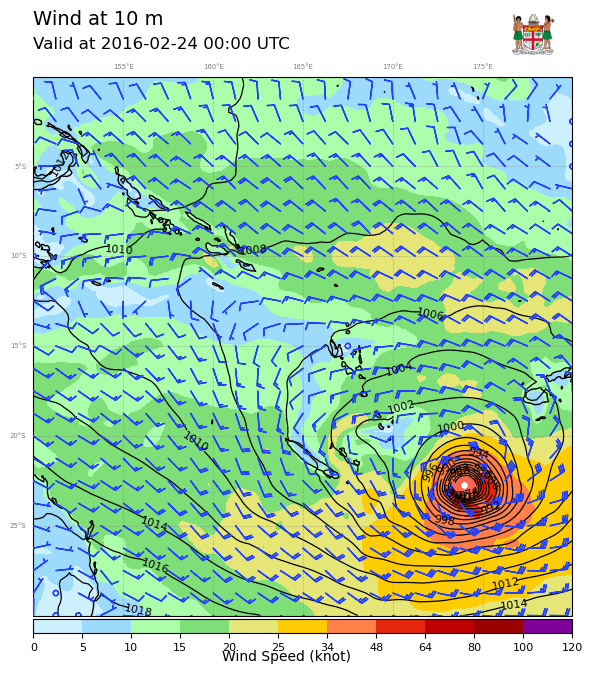

In [75]:
#======================basic plot======================
# Initiate figure and axes instance
fig, ax = plt.subplots(1, 1, figsize=(13, 7), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=185)})

# Plot wind barbs
ax.barbs(lon, lat, u10.values, v10.values, length=5, barbcolor='#2341ff', flip_barb= flip_barbs,transform=ccrs.PlateCarree(), zorder=3)

# Plot wind speed in shaded plot
shaded = ax.contourf(ds.longitude,ds.latitude, ws10, cmap=cmap, norm=norm, levels=levels, zorder=1, transform=ccrs.PlateCarree())

contour = ax.contour(ds.longitude, ds.latitude, msl, transform=ccrs.PlateCarree(), colors='black',linewidths=0.9, levels=msl_levels, zorder=2)

# Add coastlines and other features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
#======================basic plot======================

# Add contour labels
ax.clabel(contour, inline=True, fontsize=8)

# add colorbar
pos = ax.get_position() # get the original position
cbaxes = fig.add_axes([pos.x0, pos.y0 - 0.025, pos.x1 - pos.x0, 0.02])  # colorbar axes position left,bottom,width,height
plt.colorbar(shaded, cax=cbaxes, orientation='horizontal', ticks=levels, extend="both", cmap=cmap)
cbaxes.tick_params(labelsize=8)

# add colorbar text
cbar_text = 'Wind Speed (knot)'
cbpos = cbaxes.get_position()
ax.text(x=0.5, y=cbpos.y0 - 0.04, s=cbar_text, size=10, ha="center", transform=fig.transFigure)

# add title and text information
title_text = 'Wind at 10 m'
time_text = f'Valid at {time_select:%Y-%m-%d %H:%M} UTC'
ax.set_title(title_text, x=pos.x0, y=pos.y1 + 0.074, pad=25, fontsize=14,ha="left", transform=fig.transFigure)
ax.text(x=pos.x0, y=pos.y1 + 0.04, s=time_text,transform=fig.transFigure, size=12, ha="left")

# Add TC symbol
# Load and add the tropical cyclone image
cyclone_image_path = 'D:/Projects/fiji-training-2024/notebooks/day_07/hurricane.png'  # Replace with the actual path to the cyclone image
cyclone_image = plt.imread(cyclone_image_path)
imagebox_cyclone = OffsetImage(cyclone_image, zoom=0.3)  # Adjust the zoom level to resize the cyclone image

# Convert latitude and longitude to projection coordinates
xy = ax.projection.transform_point(tc_lon, tc_lat, ccrs.PlateCarree())
ab_cyclone = AnnotationBbox(imagebox_cyclone, xy, frameon=False)
ax.add_artist(ab_cyclone)

# Add logo
# add logo
pos = ax.get_position()
lgaxes = fig.add_axes([pos.x1 - 0.06, pos.y1 + 0.03, 0.06, 0.06], )  # l,b,w,h
lgaxes.imshow(plt.imread("D:/Projects/fiji-training-2024/notebooks/day_07/Coat_of_arms_of_Fiji.png"))
lgaxes.axis("off")

# Draw gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

gl.bottom_labels = False
gl.top_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'gray'}
gl.ylabel_style = {'size': 5, 'color': 'gray'}